In [1]:
from sklearn.ensemble import RandomForestClassifier
import numpy as NUM
import arcpy as ARCPY
import arcpy.da as DA
import pandas as PD
import seaborn as SEA
import matplotlib.pyplot as PLOT
import pandas as PD
import arcgisscripting as ARC
import arcpy as ARCPY
import SSUtilities as UTILS
import os as OS

In [2]:
##IMPORT DATASET FROM AN ONLINE FEATURE SERVICE
# Seagrass Data from Florida
flUrl = r'https://services3.arcgis.com/oZfKvdlWHN1MwS48/arcgis/rest/services/MachineLearningSeagrass/FeatureServer/1?token=JhUJr8S1sEV-QVD_JKNvwZdPqCdWRn0-obS8m446o0q-jzTChq6xZu6L0g9mHzjdL53OX912I5e-_VaVbAeCrtsnwdDnzYFyC9kiQ8JCbP2DzJq6dfxU1f_i2W7_j-SjITmTozjRJLofSwq5K2DvBMyXLu5IQiEioYyZCl6IbfMxju3dbmA0Es22oJmxKCig_D3cFNZFfoGTta8711I4bbdA4zW0xXvS26OS-IUwY9U.'
#Names of Prediction Variables
predictVars = ['salinity', 'temp', 'phosphate','nitrate', 
               'silicate', 'dissO2', 'NameEMU']
#Name of Classification Variable
classVar = ['Present']
#List of all Variables
allVars = predictVars + classVar
#Get Data from ArcGIS Online
FlLayer = DA.FeatureClassToNumPyArray(flUrl, ["SHAPE@XY"] + allVars)
#Obtain Spatial Reference
spatRef = ARCPY.Describe(flUrl).spatialReference
#Define Main Dataframe
data = PD.DataFrame(FlLayer, columns = allVars)
#Display Portion of the Data Frame
data.head()

,salinity,temp,phosphate,nitrate,silicate,dissO2,NameEMU,Present
0,35.694950,24.75329,0.070516,0.503541,3.878356,5.038187,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0
1,35.985001,24.13740,0.124987,0.836354,1.521608,4.710738,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0
2,35.581039,18.00565,1.032444,15.172270,10.742860,3.839985,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",1
3,35.469360,14.55408,0.936634,14.109170,9.925514,3.654587,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",1
4,35.413799,13.48950,0.980522,14.746720,10.737210,3.721700,"Epipelagic, Warm to Very Warm, Euhaline, Oxic,...",0


In [3]:
#Process Categorical Data for Analysis
#Create Numeric Fields for One-Hot Encoding of the Categorical Variable
catVars = PD.get_dummies(data[predictVars[-1]])
#Remove raw Categories from Dataset
data = data.drop(predictVars[-1], axis = 1)
#Add Processed Categories Back into the Data Frame
data = data.join(catVars)
#Abbreviate Long Categorical Variable Names
newNames = ['c1','c2','c3']
for ind, name in enumerate(newNames):
    data.rename(columns={data.columns[len(predictVars)+ind]:name}, inplace=True)
#Update Predict Variable Names
predictVarsNew = predictVars[:-1] + newNames
#Display Portion of the Data Frame
data.head()

,salinity,temp,phosphate,nitrate,silicate,dissO2,Present,c1,c2,c3
0,35.694950,24.75329,0.070516,0.503541,3.878356,5.038187,0,0,1,0
1,35.985001,24.13740,0.124987,0.836354,1.521608,4.710738,0,0,1,0
2,35.581039,18.00565,1.032444,15.172270,10.742860,3.839985,1,0,1,0
3,35.469360,14.55408,0.936634,14.109170,9.925514,3.654587,1,0,1,0
4,35.413799,13.48950,0.980522,14.746720,10.737210,3.721700,0,0,1,0


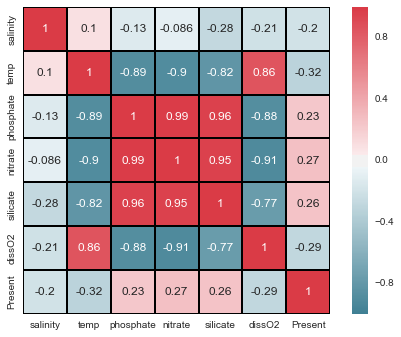

In [4]:
##EVALUATE CORRELATION BETWEEN PREDICTORS- EXCLUDE CATEGORICAL
#Calculate Correlation Coefficient between Prediction Variables
corr = data.drop(data.columns[-3:], axis = 1).astype('float64').corr()

#Plot Correlation Matrix Between Prediction Variables
ax = SEA.heatmap(corr, cmap=SEA.diverging_palette(220, 10, as_cmap=True),
            square=True, annot = True, linecolor = 'k', linewidths = 1)

PLOT.show()

In [5]:
##PERFORM RANDOM FOREST CLASSIFICATION
#Fraction of data to be used in Training
fracNum = 0.1
#Seperate the Data into Training and Test Datasets
train_c1 = data[data[classVar[0]] == 1].sample(frac = fracNum)
train_c0 = data[data[classVar[0]] == 0].sample(frac = fracNum)
#Create Training Dataset
train_set = PD.concat([train_c0, train_c1])
#Create Testing Dataset
test_set = data.drop(train_set.index)
#Encode Seagrass Presence as Classes
indicator, _ = PD.factorize(train_set[classVar[0]])
#Print Test and Train Data Set Sizes
print('Training Data Size = ' + str(train_set.size))
print('Test Data Size = ' + str(test_set.size))

Training Data Size = 100000
Test Data Size = 900000


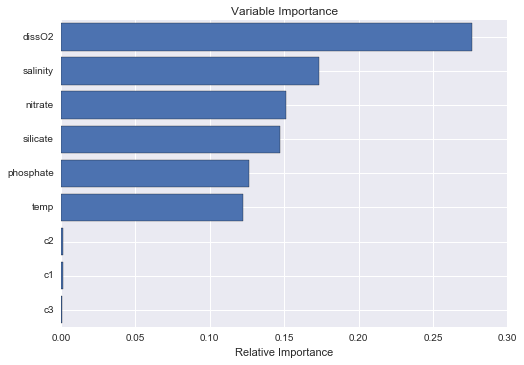

In [6]:
##Create Random Forest Classification Object
rfco = RandomForestClassifier(n_estimators = 500, oob_score = True)
#Perform Classification Using Training Set
rfco.fit(train_set[predictVarsNew], indicator)
#Plot Variable Importance
#Dummy Variables for Y-Ticks
pos = NUM.arange(len(predictVarsNew)) + .5
#Sort Variables wrt. to Their Importance
imp_sorted = NUM.argsort(rfco.feature_importances_)
#New List of Sorted Variable Names
sortedVars = [predictVarsNew[i] for i in imp_sorted]
#Plot Variable Importances
PLOT.barh(pos, rfco.feature_importances_[imp_sorted], align='center')
PLOT.yticks(pos, sortedVars)
PLOT.xlabel('Relative Importance')
PLOT.title('Variable Importance')
PLOT.show()

In [7]:
#Predict Seagrass Occurance for the Test Dataset
seagrassPred = rfco.predict(test_set[predictVarsNew])
#Calculate Prediction Accuracy
test_seagrass = test_set.as_matrix(columns =[classVar])
test_seagrass = test_seagrass.flatten()
#Calculate Estimation Error
error = NUM.sum(test_seagrass - seagrassPred)/len(seagrassPred) * 100
#Print Accuracy Metrics
print('Accuracy = ' + str(100 - NUM.abs(error)) + ' % ')
print('Locations with Seagrass = ' + str(len(NUM.where(test_seagrass==1)[0])) )
print('Predicted Locations with Seagrass = ' + str(len(NUM.where(seagrassPred==1)[0])))

Accuracy = 99.8955555556 % 
Locations with Seagrass = 27787
Predicted Locations with Seagrass = 27881


In [8]:
##BRING OUTPUT BACK INTO ARCGIS
#Allow overwriting Feature Classes
ARCPY.env.overwriteOutput = True
#Get Indexes for the Test Dataset
outputDir = r'C:\Users\orhu8849\Documents\ArcGIS\Projects\UC_2017_ML_Seminar\UC_2017_ML_Seminar.gdb'
nameFC = 'FlPredSeagrass'
#Locations with Seagrass
grassExists = FlLayer[["SHAPE@XY"]][test_set.index[NUM.where(seagrassPred==1)]]
# Write Locations with Seagrass to Feature Class
ARCPY.da.NumPyArrayToFeatureClass(grassExists, OS.path.join(outputDir, nameFC), ['SHAPE@XY'], spatRef)